In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision, Coalescence
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot
import matplotlib

from PySDM.initialisation.spectra import Exponential
from PySDM.physics.collision_kernels import Golovin, Geometric, ConstantK, Hydrodynamic
from PySDM.physics.coalescence_efficiencies import Berry1967, ConstEc, Schlottke2010
from PySDM.physics.breakup_efficiencies import ConstEb
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS, ExponFrag, Gaussian
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

In [3]:
def run_box0(k, step):

    @strict
    class Settings:

        def __init__(self):
            self.formulae = Formulae()
            self.n_sd = 2**k
            self.n_part = 100 / si.cm**3
            self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
            self.dv = 1 * si.m**3
            self.norm_factor = self.n_part * self.dv
            self.rho = 1000 * si.kilogram / si.metre**3
            self.dt = 1 * si.seconds
            self.adaptive = False
            self.seed = 44
            self._steps = [0]
            self.kernel = Golovin(b=1500 / si.second)
            self.coal_eff = ConstEc(Ec=0.0)
            self.fragmentation = AlwaysN(n=2.5)
            self.break_eff = ConstEb(1.0) # no "bouncing"
            self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
            self.radius_bins_edges = np.logspace(np.log10(0.1 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
            self.radius_range = [0 * si.um, 1e6 * si.um]

        @property
        def output_steps(self):
            return [int(step/self.dt) for step in self._steps]
    settings = Settings()
    backend = CPU

    builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
    breakup = Collision(settings.kernel, settings.coal_eff, settings.break_eff, settings.fragmentation, adaptive=settings.adaptive)
    builder.add_dynamic(breakup)
    products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
    core = builder.build(attributes, products)

    # run
    core.run(step - core.n_steps)

    x=settings.radius_bins_edges[:-1] / si.micrometres, 
    y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho
    
    return (x,y)

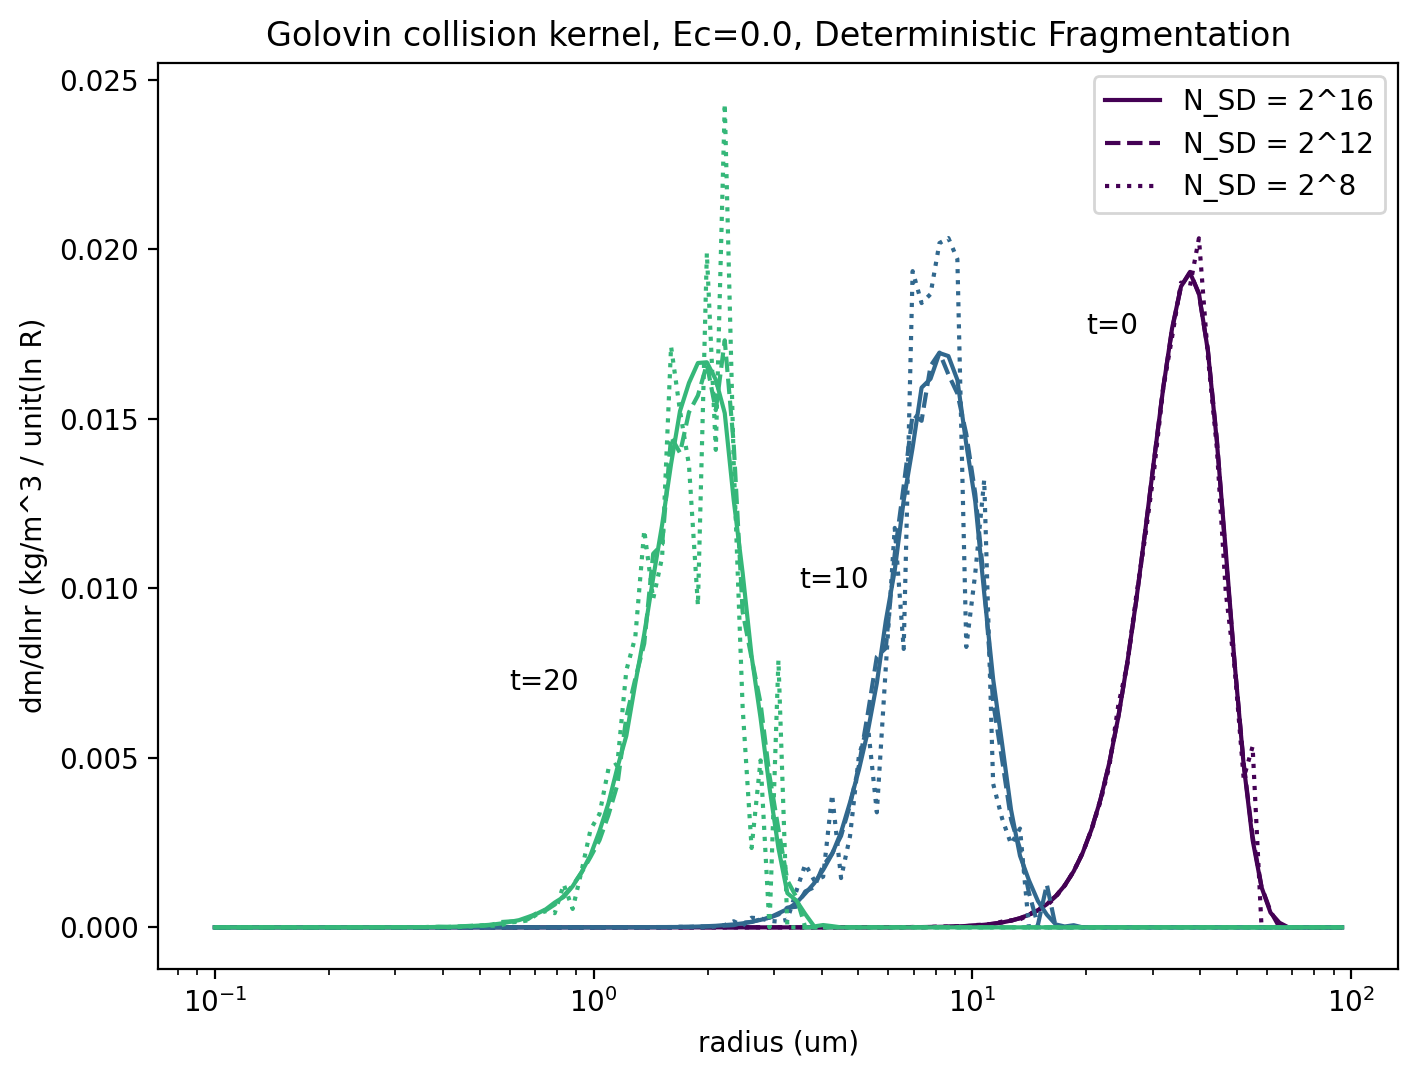

In [4]:
cmap = matplotlib.cm.get_cmap('viridis')
legend_entries = []
t_steps = [0, 10, 20]
pyplot.figure(figsize=(8,6),dpi=200)
for (i,step) in enumerate(t_steps):
    k=16
    (x,y) = run_box0(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='-')
    legend_entries.append("N_SD = 2^" + str(k))

    k=12
    (x,y) = run_box0(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='--')
    legend_entries.append("N_SD = 2^" + str(k))

    k=8
    (x,y) = run_box0(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='dotted')
    legend_entries.append("N_SD = 2^" + str(k))

pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr (kg/m^3 / unit(ln R)")
pyplot.legend(legend_entries[0:3])
pyplot.annotate('t=0',(20.0, 0.0175))
pyplot.annotate('t='+str(t_steps[1]),(3.5, 0.01))
pyplot.annotate('t='+str(t_steps[2]),(0.6, 0.007))
pyplot.title("Golovin collision kernel, Ec=0.0, Deterministic Fragmentation")
pyplot.savefig('convergence_test_0.png')

In [5]:
def run_box1(k, step):

    @strict
    class Settings:

        def __init__(self):
            self.formulae = Formulae()
            self.n_sd = 2**k
            self.n_part = 100 / si.cm**3
            self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
            self.dv = 1 * si.m**3
            self.norm_factor = self.n_part * self.dv
            self.rho = 1000 * si.kilogram / si.metre**3
            self.dt = 1 * si.seconds
            self.adaptive = False
            self.seed = 44
            self._steps = [0]
            self.kernel = Golovin(b=1500 / si.second)
            self.coal_eff = ConstEc(Ec=0.0)
            self.fragmentation = ExponFrag(scale=10.0 * si.micrometres)
            self.break_eff = ConstEb(1.0) # no "bouncing"
            self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
            self.radius_bins_edges = np.logspace(np.log10(0.1 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
            self.radius_range = [0 * si.um, 1e6 * si.um]

        @property
        def output_steps(self):
            return [int(step/self.dt) for step in self._steps]
    settings = Settings()
    backend = CPU

    builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
    breakup = Collision(settings.kernel, settings.coal_eff, settings.break_eff, settings.fragmentation, adaptive=settings.adaptive)
    builder.add_dynamic(breakup)
    products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
    core = builder.build(attributes, products)

    # run
    core.run(step - core.n_steps)

    x=settings.radius_bins_edges[:-1] / si.micrometres, 
    y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho
    
    return (x,y)

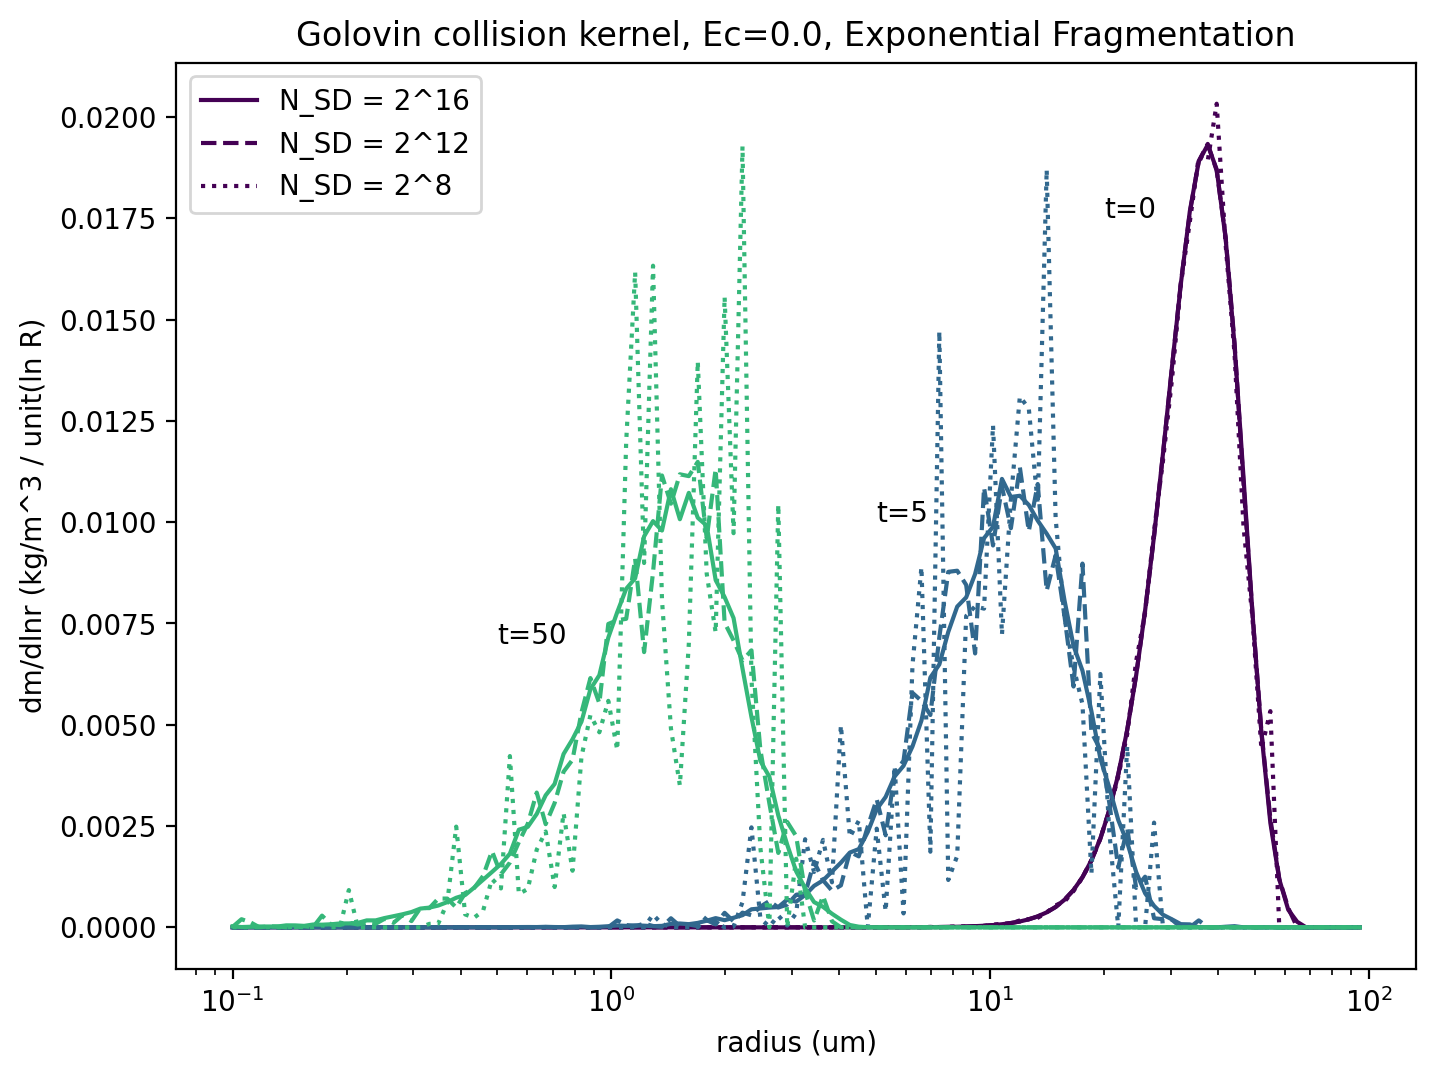

In [6]:
cmap = matplotlib.cm.get_cmap('viridis')
legend_entries = []
t_steps = [0, 5, 50]
pyplot.figure(figsize=(8,6),dpi=200)
for (i,step) in enumerate(t_steps):
    k=16
    (x,y) = run_box1(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='-')
    legend_entries.append("N_SD = 2^" + str(k))

    k=12
    (x,y) = run_box1(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='--')
    legend_entries.append("N_SD = 2^" + str(k))

    k=8
    (x,y) = run_box1(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='dotted')
    legend_entries.append("N_SD = 2^" + str(k))

pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr (kg/m^3 / unit(ln R)")
pyplot.legend(legend_entries[0:3])
pyplot.annotate('t=0',(20.0, 0.0175))
pyplot.annotate('t='+str(t_steps[1]),(5.0, 0.01))
pyplot.annotate('t='+str(t_steps[2]),(0.5, 0.007))
pyplot.title("Golovin collision kernel, Ec=0.0, Exponential Fragmentation")
pyplot.savefig('convergence_test_1.png')

In [7]:
def run_box1c(k, step):

    @strict
    class Settings:

        def __init__(self):
            self.formulae = Formulae()
            self.n_sd = 2**k
            self.n_part = 100 / si.cm**3
            self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
            self.dv = 1 * si.m**3
            self.norm_factor = self.n_part * self.dv
            self.rho = 1000 * si.kilogram / si.metre**3
            self.dt = 1 * si.seconds
            self.adaptive = False
            self.seed = 44
            self._steps = [0]
            self.kernel = Golovin(b=1500 / si.second)
            self.coal_eff = ConstEc(Ec=1.0)
            self.fragmentation = ExponFrag(scale=10.0 * si.micrometres)
            self.break_eff = ConstEb(1.0) # no "bouncing"
            self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
            self.radius_bins_edges = np.logspace(np.log10(10.0 * si.um), np.log10(500 * si.um), num=128, endpoint=True)
            self.radius_range = [0 * si.um, 1e6 * si.um]

        @property
        def output_steps(self):
            return [int(step/self.dt) for step in self._steps]
    settings = Settings()
    backend = CPU

    builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
    breakup = Collision(settings.kernel, settings.coal_eff, settings.break_eff, settings.fragmentation, adaptive=settings.adaptive)
    builder.add_dynamic(breakup)
    products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
    core = builder.build(attributes, products)

    # run
    core.run(step - core.n_steps)

    x=settings.radius_bins_edges[:-1] / si.micrometres, 
    y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho
    
    return (x,y)

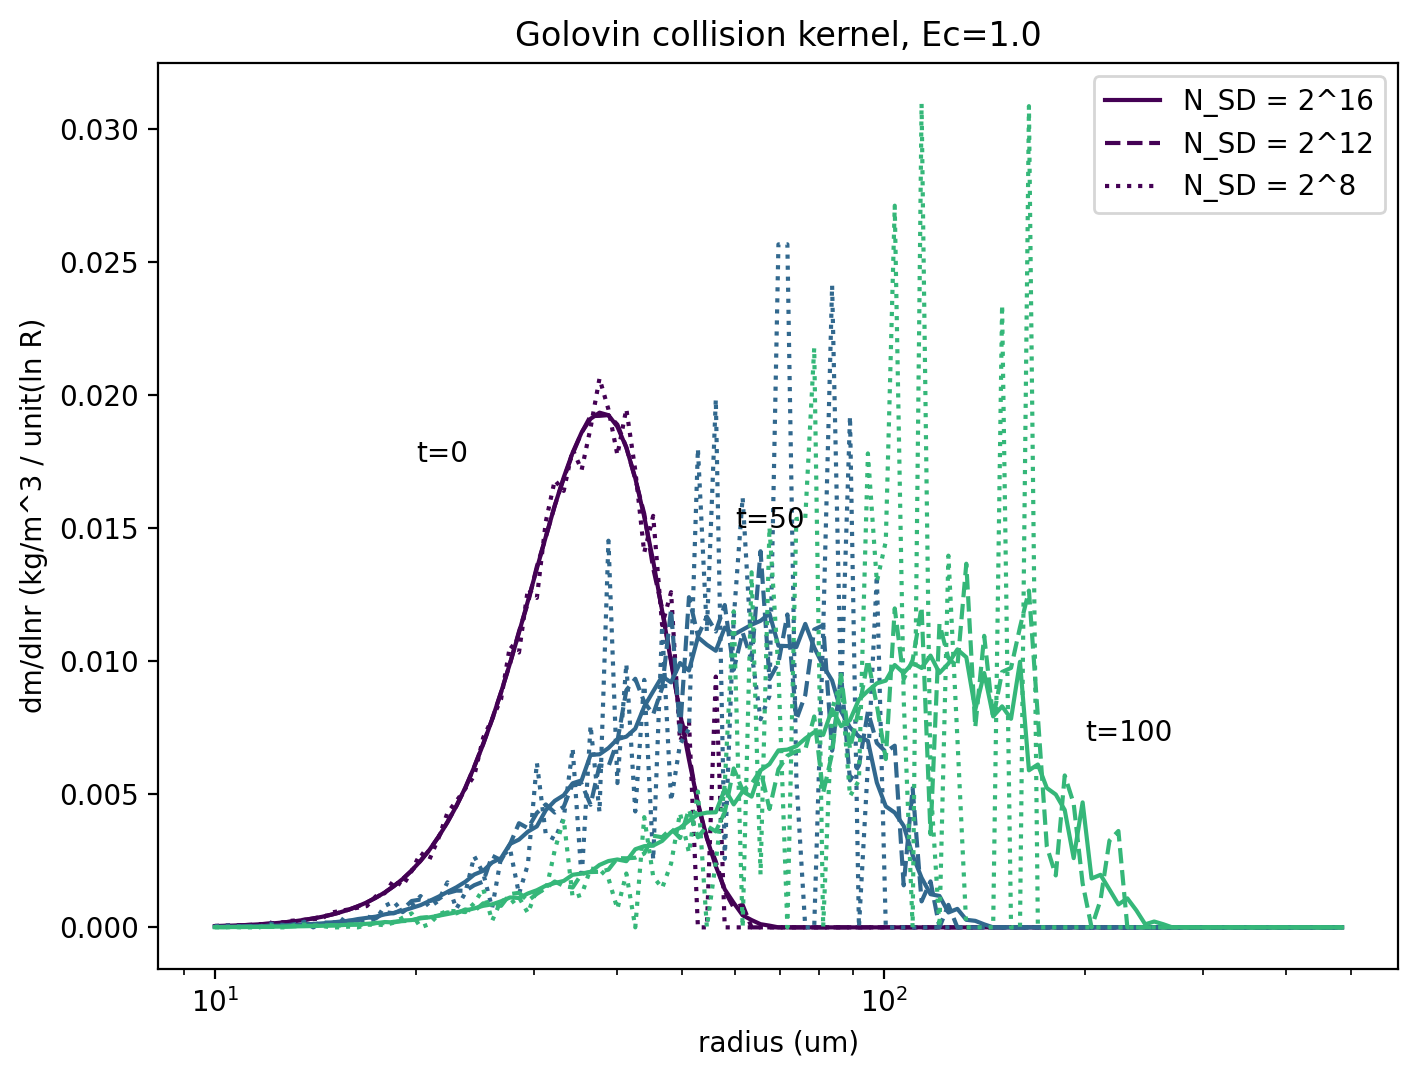

In [8]:
cmap = matplotlib.cm.get_cmap('viridis')
legend_entries = []
t_steps = [0, 50, 100]
pyplot.figure(figsize=(8,6),dpi=200)
for (i,step) in enumerate(t_steps):
    k=16
    (x,y) = run_box1c(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='-')
    legend_entries.append("N_SD = 2^" + str(k))

    k=12
    (x,y) = run_box1c(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='--')
    legend_entries.append("N_SD = 2^" + str(k))

    k=8
    (x,y) = run_box1c(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='dotted')
    legend_entries.append("N_SD = 2^" + str(k))

pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr (kg/m^3 / unit(ln R)")
pyplot.legend(legend_entries[0:3])
pyplot.annotate('t=0',(20.0, 0.0175))
pyplot.annotate('t='+str(t_steps[1]),(60.0, 0.015))
pyplot.annotate('t='+str(t_steps[2]),(200.0, 0.007))
pyplot.title("Golovin collision kernel, Ec=1.0")
pyplot.savefig('convergence_test_1c.png')

In [3]:
def run_box2(k, step):

    @strict
    class Settings:

        def __init__(self):
            self.formulae = Formulae()
            self.n_sd = 2**k
            self.n_part = 100 / si.cm**3
            self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
            self.dv = 1 * si.m**3
            self.norm_factor = self.n_part * self.dv
            self.rho = 1000 * si.kilogram / si.metre**3
            self.dt = 1 * si.seconds
            self.adaptive = False
            self.seed = 44
            self._steps = [0]
            self.kernel = Geometric()
            self.coal_eff = Berry1967()
            self.fragmentation = ExponFrag(scale=250.0 * si.micrometres)
            self.break_eff = ConstEb(1.0) # no "bouncing"
            self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
            self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(2000 * si.um), num=128, endpoint=True)
            self.radius_range = [0 * si.um, 1e6 * si.um]

        @property
        def output_steps(self):
            return [int(step/self.dt) for step in self._steps]
    settings = Settings()
    backend = CPU

    builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
    breakup = Collision(settings.kernel, settings.coal_eff, settings.break_eff, settings.fragmentation, adaptive=settings.adaptive)
    builder.add_dynamic(breakup)
    products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
    core = builder.build(attributes, products)

    # run
    core.run(step - core.n_steps)

    x=settings.radius_bins_edges[:-1] / si.micrometres, 
    y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho
    
    return (x,y)

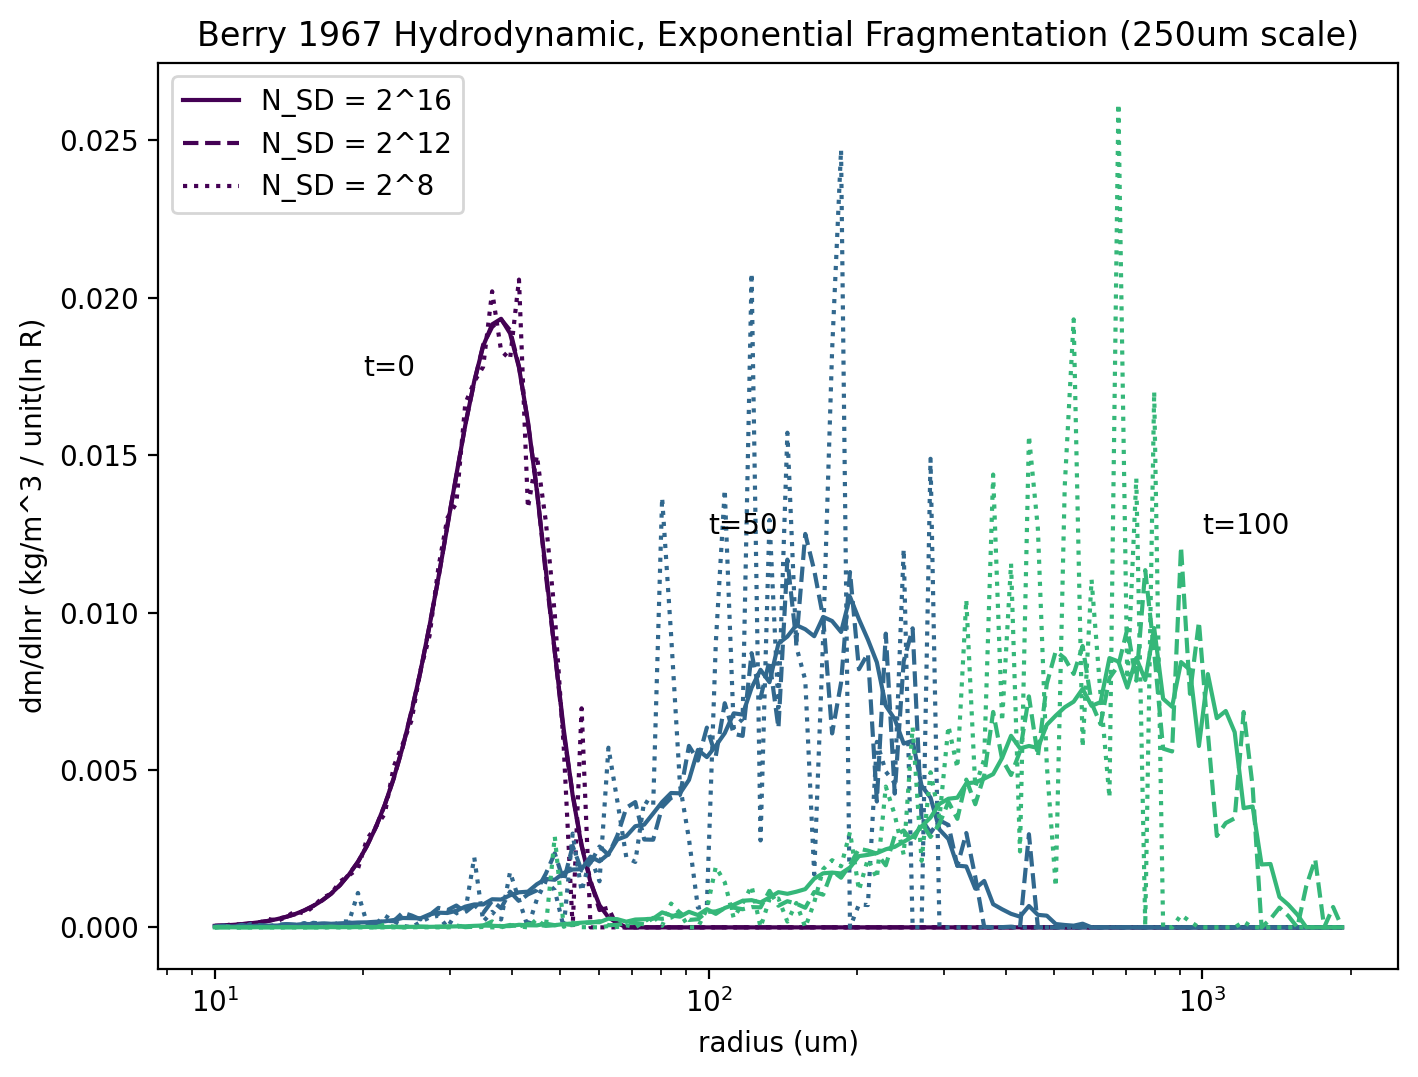

In [10]:
cmap = matplotlib.cm.get_cmap('viridis')
legend_entries = []
t_steps = [0, 50, 100]
pyplot.figure(figsize=(8,6),dpi=200)
for (i,step) in enumerate(t_steps):
    k=16
    (x,y) = run_box2(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='-')
    legend_entries.append("N_SD = 2^" + str(k))

    k=12
    (x,y) = run_box2(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='--')
    legend_entries.append("N_SD = 2^" + str(k))

    k=8
    (x,y) = run_box2(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='dotted')
    legend_entries.append("N_SD = 2^" + str(k))

pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr (kg/m^3 / unit(ln R)")
pyplot.legend(legend_entries[0:3])
pyplot.annotate('t=0',(20.0, 0.0175))
pyplot.annotate('t='+str(t_steps[1]),(100.0, 0.0125))
pyplot.annotate('t='+str(t_steps[2]),(1000.0, 0.0125))
pyplot.title("Berry 1967 Hydrodynamic, Exponential Fragmentation (250um scale)")
pyplot.savefig('convergence_test_2.png')

In [4]:
def run_box2_nobreak(k, step):

    @strict
    class Settings:

        def __init__(self):
            self.formulae = Formulae()
            self.n_sd = 2**k
            self.n_part = 100 / si.cm**3
            self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
            self.dv = 1 * si.m**3
            self.norm_factor = self.n_part * self.dv
            self.rho = 1000 * si.kilogram / si.metre**3
            self.dt = 1 * si.seconds
            self.adaptive = False
            self.seed = 45
            self._steps = [0]
            self.kernel = Hydrodynamic() #Geometric()
            self.coal_eff = Berry1967()
            self.fragmentation = ExponFrag(scale=250.0 * si.micrometres)
            self.break_eff = ConstEb(1.0) # no "bouncing"
            self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
            self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(2000 * si.um), num=128, endpoint=True)
            self.radius_range = [0 * si.um, 1e6 * si.um]

        @property
        def output_steps(self):
            return [int(step/self.dt) for step in self._steps]
    settings = Settings()
    backend = CPU

    builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
    coal = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
    builder.add_dynamic(coal)
    products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
    core = builder.build(attributes, products)

    # run
    core.run(step - core.n_steps)

    x=settings.radius_bins_edges[:-1] / si.micrometres, 
    y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho
    
    return (x,y)

Text(0.5, 1.0, 'Berry 1967 Hydrodynamic Kernel, No Breakup')

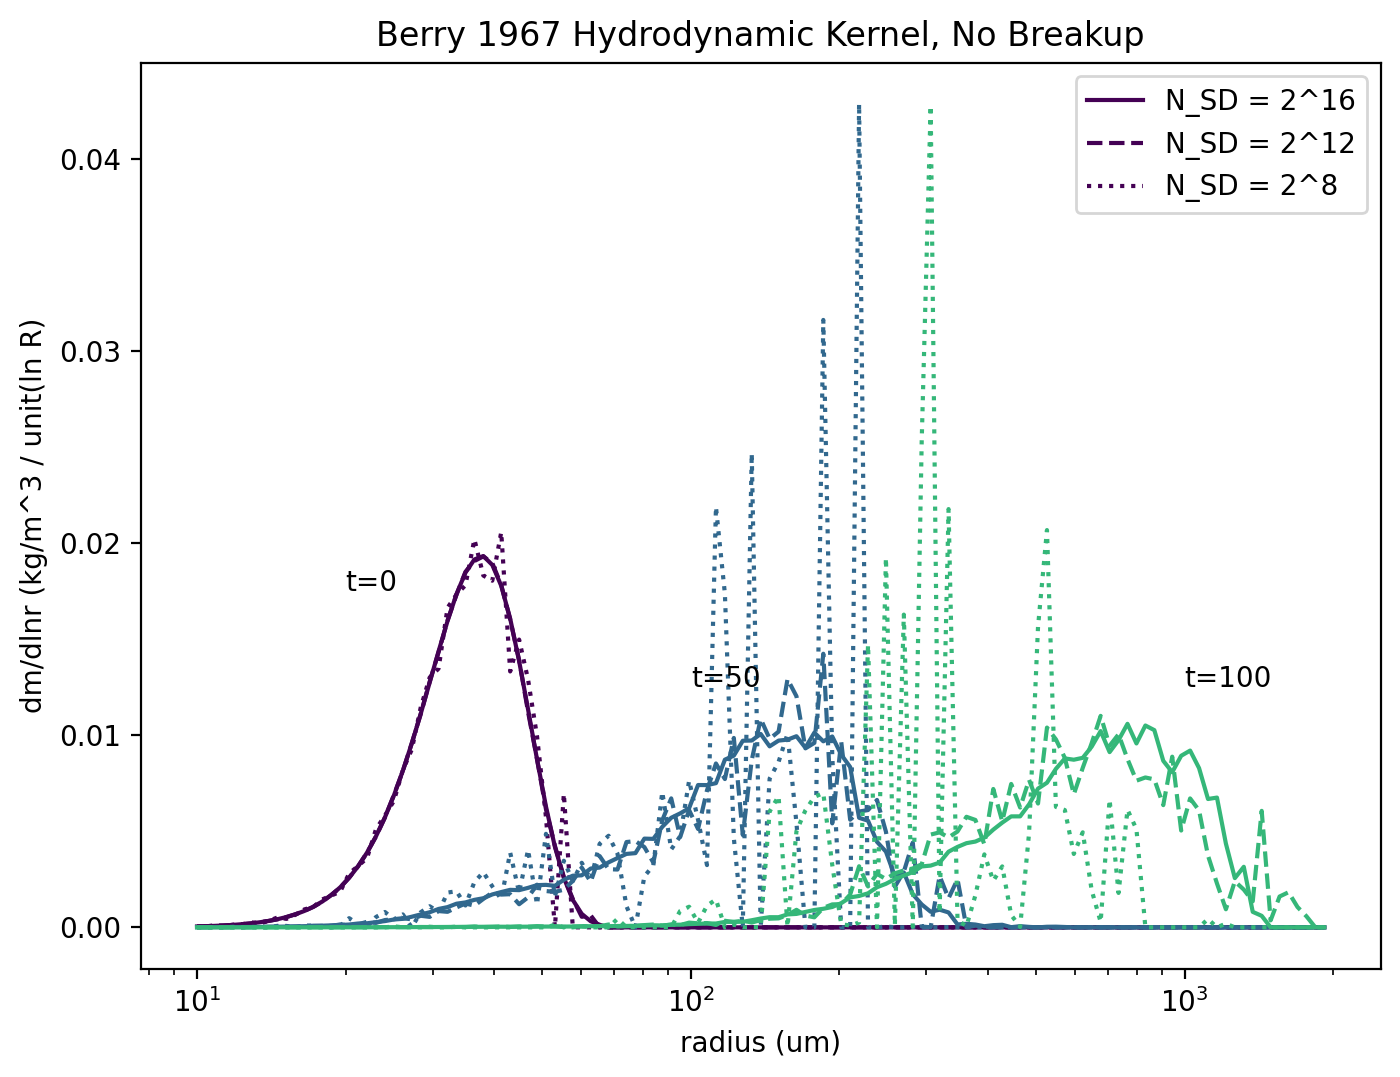

In [7]:
cmap = matplotlib.cm.get_cmap('viridis')
legend_entries = []
t_steps = [0, 50, 100]
pyplot.figure(figsize=(8,6),dpi=200)
for (i,step) in enumerate(t_steps):
    k=16
    (x,y) = run_box2_nobreak(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='-')
    legend_entries.append("N_SD = 2^" + str(k))

    k=12
    (x,y) = run_box2_nobreak(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='--')
    legend_entries.append("N_SD = 2^" + str(k))

    k=8
    (x,y) = run_box2_nobreak(k, step)
    pyplot.plot(x[0],y,color=cmap(i/len(t_steps)),linestyle='dotted')
    legend_entries.append("N_SD = 2^" + str(k))

pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr (kg/m^3 / unit(ln R)")
pyplot.legend(legend_entries[0:3])
pyplot.annotate('t=0',(20.0, 0.0175))
pyplot.annotate('t='+str(t_steps[1]),(100.0, 0.0125))
pyplot.annotate('t='+str(t_steps[2]),(1000.0, 0.0125))
pyplot.title("Berry 1967 Hydrodynamic Kernel, No Breakup")
#pyplot.savefig('convergence_test_2_nobreak.png')

## CONVERGENCE TESTING:

In [8]:
def run_box2(k, step):

    @strict
    class Settings:

        def __init__(self):
            self.formulae = Formulae()
            self.n_sd = 2**k
            self.n_part = 100 / si.cm**3
            self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
            self.dv = 1 * si.m**3
            self.norm_factor = self.n_part * self.dv
            self.rho = 1000 * si.kilogram / si.metre**3
            self.dt = 1 * si.seconds
            self.adaptive = False
            self.seed = 44
            self._steps = [0]
            self.kernel = Geometric()
            self.coal_eff = Berry1967()
            self.fragmentation = ExponFrag(scale=250.0 * si.micrometres)
            self.break_eff = ConstEb(1.0) # no "bouncing"
            self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
            self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(2000 * si.um), num=128, endpoint=True)
            self.radius_range = [0 * si.um, 1e6 * si.um]

        @property
        def output_steps(self):
            return [int(step/self.dt) for step in self._steps]
    settings = Settings()
    backend = CPU

    builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
    breakup = Collision(settings.kernel, settings.coal_eff, settings.break_eff, settings.fragmentation, adaptive=settings.adaptive)
    builder.add_dynamic(breakup)
    products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
    core = builder.build(attributes, products)

    # run
    core.run(step - core.n_steps)

    x=settings.radius_bins_edges[:-1] / si.micrometres, 
    y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho
    
    return (x,y)

In [32]:
t_steps = [120]
ks = [8]
kmax = ks[-1]

x = np.ndarray((len(ks), 127),'float64')
y = np.ndarray((len(ks), 127),'float64')
#pyplot.figure(figsize=(8,6),dpi=200)
for (i,k) in enumerate(ks):
    (xt,yt) = run_box2_nobreak(k, step)
    x[i,:] = xt[0]
    y[i,:] = yt[0]
""" pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr (kg/m^3 / unit(ln R)")
pyplot.legend(legend_entries[0:3])
pyplot.annotate('t=0',(20.0, 0.0175))
pyplot.annotate('t='+str(t_steps[1]),(100.0, 0.0125))
pyplot.annotate('t='+str(t_steps[2]),(1000.0, 0.0125))∂
pyplot.title("Berry 1967 Hydrodynamic Kernel, No Breakup") """
#pyplot.savefig('convergence_test_2_nobreak.png')

' pyplot.xscale("log")\npyplot.xlabel("radius (um)")\npyplot.ylabel("dm/dlnr (kg/m^3 / unit(ln R)")\npyplot.legend(legend_entries[0:3])\npyplot.annotate(\'t=0\',(20.0, 0.0175))\npyplot.annotate(\'t=\'+str(t_steps[1]),(100.0, 0.0125))\npyplot.annotate(\'t=\'+str(t_steps[2]),(1000.0, 0.0125))∂\npyplot.title("Berry 1967 Hydrodynamic Kernel, No Breakup") '

In [33]:
x

array([[  10.        ,   10.42601502,   10.87017893,   11.33326488,
          11.81607899,   12.31946171,   12.84428929,   13.39147531,
          13.96197228,   14.55677327,   15.17691369,   15.82347301,
          16.49757674,   17.20039829,   17.9331611 ,   18.69714071,
          19.49366699,   20.32412649,   21.18996482,   22.09268915,
          23.0338709 ,   24.01514841,   25.03822981,   26.10489602,
          27.21700381,   28.37648907,   29.58537013,   30.84575135,
          32.1598267 ,   33.52988364,   34.95830706,   36.44758346,
          38.00030527,   39.61917537,   41.30701177,   43.06675253,
          44.90146089,   46.81433059,   48.8086914 ,   50.88801499,
          53.05592088,   55.31618282,   57.67273532,   60.12968049,
          62.69129522,   65.36203859,   68.14655963,   71.04970546,
          74.07652966,   77.23230111,   80.52251318,   83.95289322,
          87.5294126 ,   91.25829708,   95.14603765,   99.1994018 ,
         103.42544535,  107.83152472,  112.42530